# Session 12: Market Basket Analysis - Apriori Algorithm

## Learning Objectives
- Understand the concept of Market Basket Analysis
- Learn key metrics: Support, Confidence, and Lift
- Implement the Apriori algorithm
- Extract and interpret association rules
- Apply MBA to real-world retail scenarios

## What is Market Basket Analysis?

**Market Basket Analysis (MBA)** is a data mining technique used to discover associations between items that frequently occur together in transactions.

### Common Applications:
- **Retail**: Product placement and cross-selling
- **E-commerce**: Recommendation systems
- **Healthcare**: Medical diagnosis patterns
- **Web Analytics**: Page visit patterns

### Example:
If customers who buy bread and butter also tend to buy milk, we have an association rule:
```
{Bread, Butter} → {Milk}
```

## Key Metrics

### 1. Support
Measures how frequently an itemset appears in the dataset.

$$\text{Support}(A) = \frac{\text{Transactions containing A}}{\text{Total transactions}}$$

### 2. Confidence
Measures how often items in B appear in transactions that contain A.

$$\text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)}$$

### 3. Lift
Measures how much more likely B is purchased when A is purchased.

$$\text{Lift}(A \rightarrow B) = \frac{\text{Confidence}(A \rightarrow B)}{\text{Support}(B)}$$

- **Lift > 1**: Items are likely to be bought together
- **Lift = 1**: No association
- **Lift < 1**: Items are unlikely to be bought together

## Install Required Libraries

In [ ]:
# Install mlxtend library for Apriori algorithm
!pip install mlxtend -q

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Real Market Basket Dataset

Let's load the actual retail transaction data from MBAdata.csv.

In [ ]:
# Load the dataset
df_raw = pd.read_csv('MBAdata.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df_raw.shape}")
print(f"Total records: {len(df_raw):,}")
print(f"\nColumn names: {df_raw.columns.tolist()}")
print("\nFirst few rows:")
print(df_raw.head(10))

# Check data types and missing values
print("\n" + "="*70)
print("Dataset Info:")
print("="*70)
print(df_raw.info())

print("\n" + "="*70)
print("Missing Values:")
print("="*70)
print(df_raw.isnull().sum())

Dataset loaded successfully!

Dataset shape: (38765, 3)
Total records: 38,765

Column names: ['memberNumber', 'Date', 'itemDescription']

First few rows:
   memberNumber        Date   itemDescription
0          1808  21-07-2015    tropical fruit
1          1808  21-07-2015             candy
2          2300  19-09-2015         pip fruit
3          1187  12-12-2015  other vegetables
4          3037  01-02-2015        whole milk
5          4941  14-02-2015        rolls/buns
6          4501  08-05-2015  other vegetables
7          3803  23-12-2015        pot plants
8          2762  20-03-2015        whole milk
9          4119  12-02-2015    tropical fruit

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   memberNumber     38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null 

## Exploratory Data Analysis

Let's explore the dataset to understand the transaction patterns.

In [ ]:
# Basic statistics
print("Unique Statistics:")
print("="*70)
print(f"Number of unique members: {df_raw['memberNumber'].nunique():,}")
print(f"Number of unique items: {df_raw['itemDescription'].nunique():,}")
print(f"Number of unique dates: {df_raw['Date'].nunique():,}")

# Top 20 most popular items
print("\n" + "="*70)
print("Top 20 Most Purchased Items:")
print("="*70)
top_items = df_raw['itemDescription'].value_counts().head(20)
print(top_items)

Unique Statistics:
Number of unique members: 3,898
Number of unique items: 167
Number of unique dates: 728

Top 20 Most Purchased Items:
itemDescription
whole milk            2502
other vegetables      1898
rolls/buns            1715
soda                  1514
yogurt                1334
root vegetables       1071
tropical fruit        1032
bottled water          933
sausage                924
citrus fruit           812
pastry                 785
pip fruit              744
shopping bags          731
canned beer            717
bottled beer           687
whipped/sour cream     662
newspapers             596
frankfurter            580
brown bread            571
pork                   566
Name: count, dtype: int64


## Visualize Item Popularity

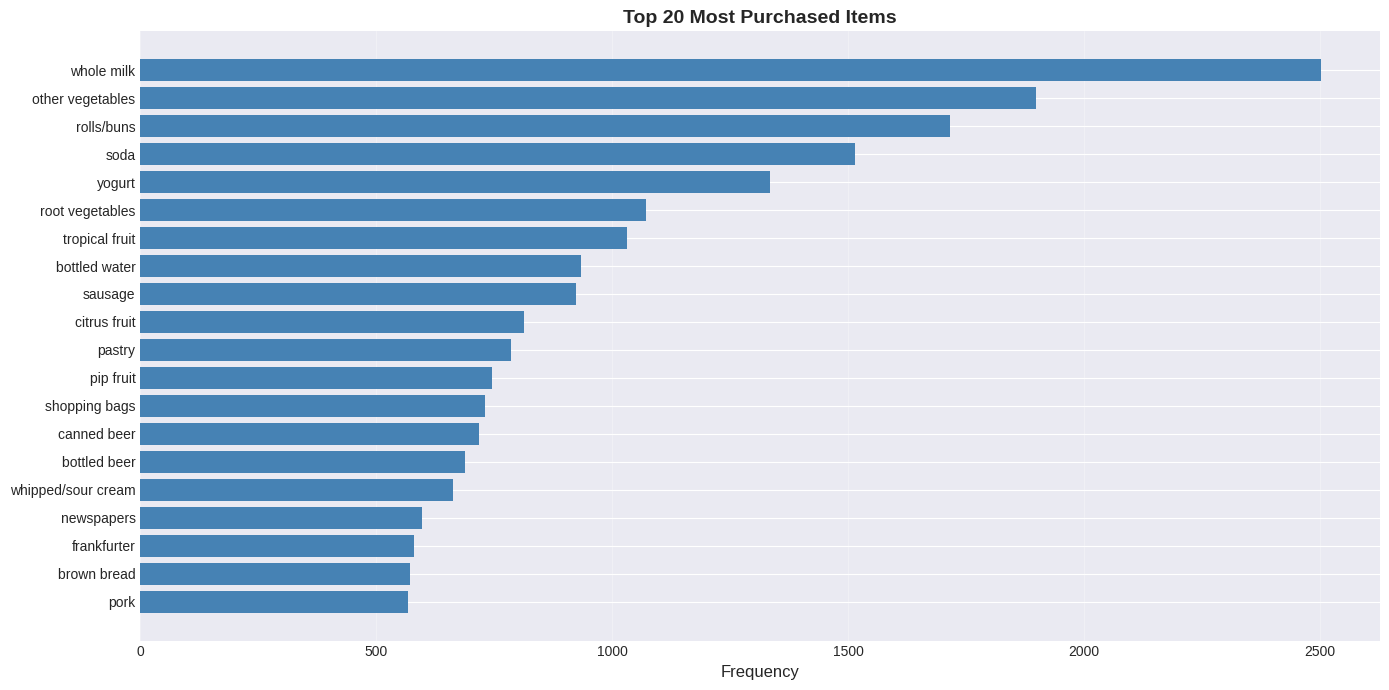

In [ ]:
# Visualize top 20 items
plt.figure(figsize=(14, 7))
top_items = df_raw['itemDescription'].value_counts().head(20)
plt.barh(range(len(top_items)), top_items.values, color='steelblue')
plt.yticks(range(len(top_items)), top_items.index)
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 20 Most Purchased Items', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Prepare Data for Apriori Algorithm

We need to group items by transaction (memberNumber + Date combination) and convert to the required format.

In [ ]:
# Create transaction ID by combining memberNumber and Date
df_raw['TransactionID'] = df_raw['memberNumber'].astype(str) + '_' + df_raw['Date'].astype(str)

# Group items by transaction
transactions = df_raw.groupby('TransactionID')['itemDescription'].apply(list).values.tolist()

print(f"Total number of transactions: {len(transactions):,}")
print(f"\nSample transactions:")
for i, transaction in enumerate(transactions[:5], 1):
    print(f"Transaction {i}: {transaction}")

Total number of transactions: 14,963

Sample transactions:
Transaction 1: ['sausage', 'whole milk', 'semi-finished bread', 'yogurt']
Transaction 2: ['whole milk', 'pastry', 'salty snack']
Transaction 3: ['canned beer', 'misc. beverages']
Transaction 4: ['sausage', 'hygiene articles']
Transaction 5: ['soda', 'pickled vegetables']


## Transform Data to Binary Matrix

Convert the transaction list to a binary matrix format required by the Apriori algorithm.

In [ ]:
# Transform transactions to binary matrix
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

print("Binary Transaction Matrix created!")
print(f"Shape: {df_encoded.shape}")
print(f"Rows (Transactions): {df_encoded.shape[0]:,}")
print(f"Columns (Unique Items): {df_encoded.shape[1]:,}")
print("\nFirst few rows:")
print(df_encoded.head(10))

Binary Transaction Matrix created!
Shape: (14963, 167)
Rows (Transactions): 14,963
Columns (Unique Items): 167

First few rows:
   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  beverages  bottled beer  bottled water  brandy  brown bread  butter  butter milk  cake bar  candles  candy  canned beer  canned fish  canned fruit  canned vegetables  cat food  cereals  chewing gum  chicken  chocolate  chocolate marshmallow  citrus fruit  cleaner  cling film/bags  cocoa drinks  coffee  condensed milk  cooking chocolate  cookware  cream  cream cheese    curd  curd cheese  decalcifier  dental care  dessert  detergent  dish cleaner  dishes  dog food  domestic eggs  female sanitary products  finished products   fish  flour  flower (seeds)  flower soil/fertilizer  frankfurter  frozen chicken  frozen dessert  frozen fish  frozen fruits  frozen meals  frozen potato products  frozen vegetables  fruit/vegetable

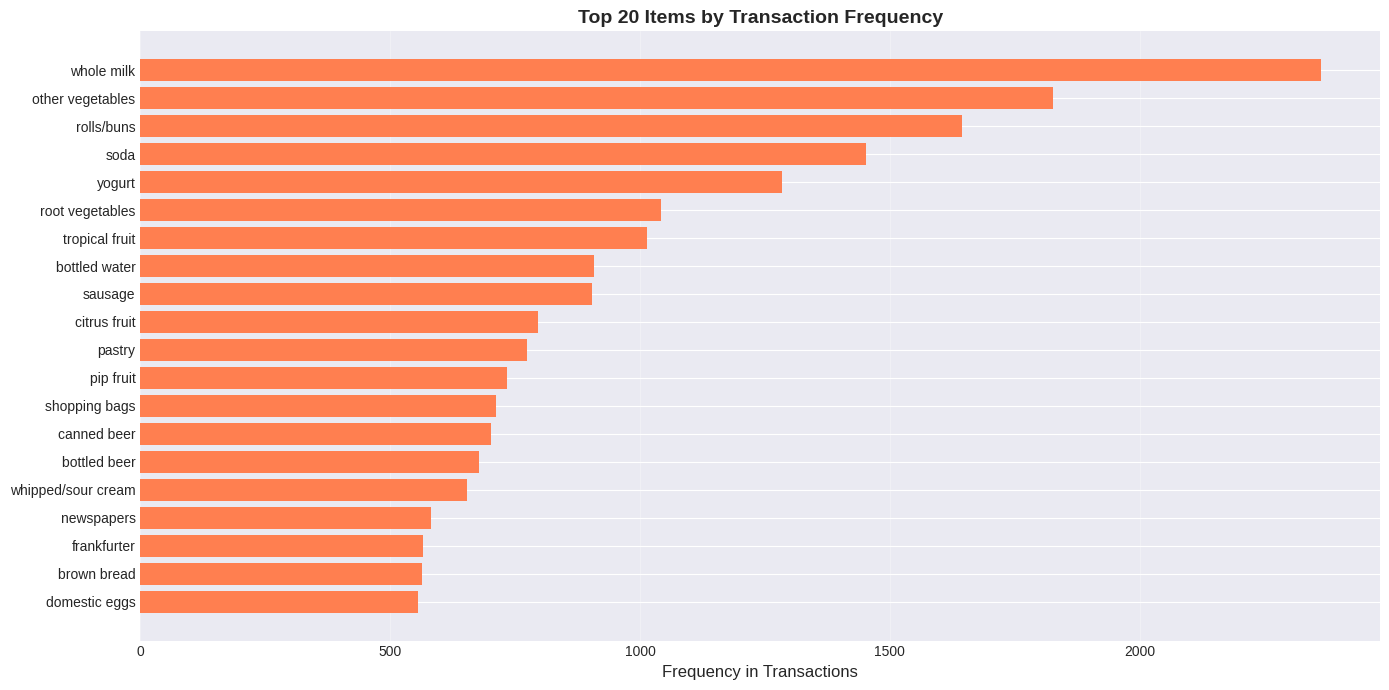


Top 20 Item Frequencies:
whole milk            2363
other vegetables      1827
rolls/buns            1645
soda                  1453
yogurt                1285
root vegetables       1041
tropical fruit        1014
bottled water          908
sausage                903
citrus fruit           795
pastry                 774
pip fruit              734
shopping bags          712
canned beer            702
bottled beer           678
whipped/sour cream     654
newspapers             582
frankfurter            565
brown bread            563
domestic eggs          555
dtype: int64


In [ ]:
# Item frequency analysis
item_frequency = df_encoded.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 7))
plt.barh(range(len(item_frequency)), item_frequency.values, color='coral')
plt.yticks(range(len(item_frequency)), item_frequency.index)
plt.xlabel('Frequency in Transactions', fontsize=12)
plt.title('Top 20 Items by Transaction Frequency', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 20 Item Frequencies:")
print(item_frequency)

## Apply Apriori Algorithm

Now let's find frequent itemsets using the Apriori algorithm with a minimum support threshold.

In [ ]:
# Apply Apriori algorithm with min_support = 0.005 (0.5%)
# Lower threshold to find more itemsets that appear together
print("Running Apriori algorithm... (this may take a moment)")
print("Using min_support = 0.005 (items must appear in at least 0.5% of transactions)")

frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True, max_len=3)

print(f"\n✓ Apriori algorithm completed!")
print(f"Total frequent itemsets found: {len(frequent_itemsets):,}")

# Show breakdown by itemset size
itemset_size_counts = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()
print(f"\nBreakdown by itemset size:")
for size, count in itemset_size_counts.items():
    print(f"  Size {size}: {count:,} itemsets")

print("\n" + "="*70)
print("Top 20 Frequent Itemsets by Support:")
print("="*70)
print(frequent_itemsets.sort_values('support', ascending=False).head(20))

Running Apriori algorithm... (this may take a moment)
Using min_support = 0.005 (items must appear in at least 0.5% of transactions)

✓ Apriori algorithm completed!
Total frequent itemsets found: 126

Breakdown by itemset size:
  Size 1: 89 itemsets
  Size 2: 37 itemsets

Top 20 Frequent Itemsets by Support:
     support              itemsets
87  0.157923          (whole milk)
53  0.122101    (other vegetables)
66  0.109938          (rolls/buns)
75  0.097106                (soda)
88  0.085879              (yogurt)
67  0.069572     (root vegetables)
81  0.067767      (tropical fruit)
6   0.060683       (bottled water)
70  0.060349             (sausage)
19  0.053131        (citrus fruit)
56  0.051728              (pastry)
60  0.049054           (pip fruit)
73  0.047584       (shopping bags)
12  0.046916         (canned beer)
5   0.045312        (bottled beer)
84  0.043708  (whipped/sour cream)
50  0.038896          (newspapers)
29  0.037760         (frankfurter)
7   0.037626         (bro

Distribution of Itemset Lengths:
itemsets
1    89
2    37
Name: count, dtype: int64


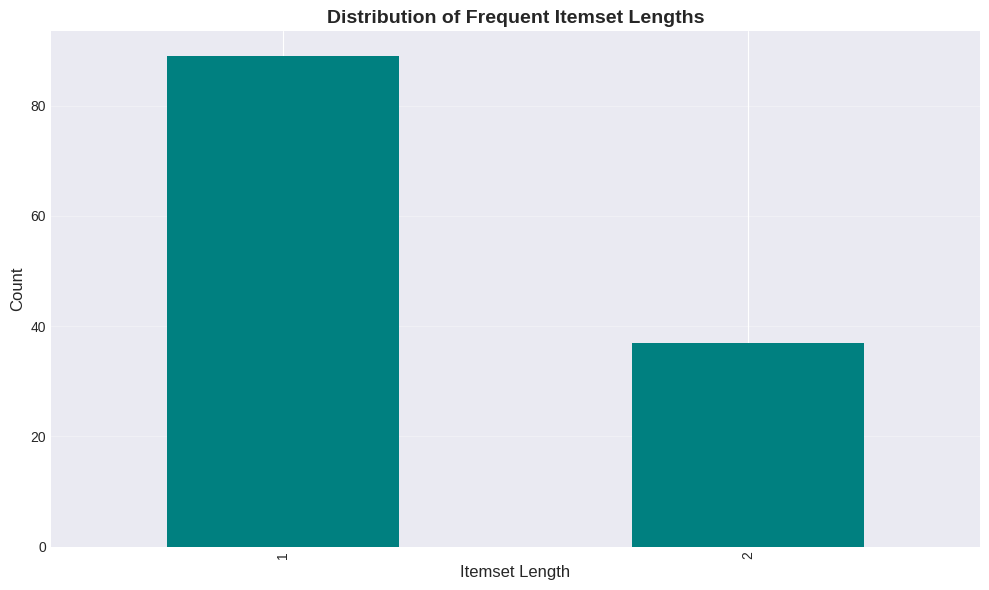

In [ ]:
# Analyze itemset lengths
itemset_lengths = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print("Distribution of Itemset Lengths:")
print(itemset_lengths.value_counts().sort_index())

# Visualize
plt.figure(figsize=(10, 6))
itemset_lengths.value_counts().sort_index().plot(kind='bar', color='teal')
plt.xlabel('Itemset Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Frequent Itemset Lengths', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# First, let's check what we have in frequent_itemsets
print("Checking frequent itemsets with length > 1:")
multi_item_sets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
print(f"Number of itemsets with 2+ items: {len(multi_item_sets)}")

if len(multi_item_sets) > 0:
    print("\nSample multi-item frequent itemsets:")
    print(multi_item_sets.head(10))
else:
    print("\n⚠️ No multi-item frequent itemsets found!")
    print("This means items don't frequently appear together with current support threshold.")
    print("We'll try to generate rules anyway with a lower confidence threshold.")

print("\n" + "="*70)
print("Generating association rules...")
print("="*70)

# Try generating rules with lower confidence threshold (0.01 = 1%)
# Also try different metrics to ensure we get some rules
try:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

    if len(rules) == 0:
        print("\n⚠️ No rules found with confidence threshold. Trying with support metric...")
        rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.001)

    # Sort by lift
    rules = rules.sort_values('lift', ascending=False)

    print(f"\n✓ Association rules generated!")
    print(f"Total rules found: {len(rules):,}")

    if len(rules) > 0:
        print("\n" + "="*70)
        print("Top 20 Association Rules by Lift:")
        print("="*70)
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))
    else:
        print("\n❌ No association rules could be generated from the frequent itemsets.")
        print("This suggests that items in your dataset don't have strong co-occurrence patterns.")
        print("Recommendations:")
        print("  1. Lower the min_support in Apriori (try 0.005 or 0.001)")
        print("  2. Check if your transaction data has enough variety")
        print("  3. Ensure transactions are properly grouped by customer+date")

except Exception as e:
    print(f"\n❌ Error generating rules: {e}")
    print("The frequent_itemsets may only contain single items.")
    rules = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'])

Checking frequent itemsets with length > 1:
Number of itemsets with 2+ items: 37

Sample multi-item frequent itemsets:
     support                           itemsets
89  0.007151         (bottled beer, whole milk)
90  0.005480  (other vegetables, bottled water)
91  0.007151        (whole milk, bottled water)
92  0.006015          (canned beer, whole milk)
93  0.007151         (citrus fruit, whole milk)
94  0.005280        (whole milk, domestic eggs)
95  0.005146    (other vegetables, frankfurter)
96  0.005280          (frankfurter, whole milk)
97  0.005614           (whole milk, newspapers)
98  0.010559     (other vegetables, rolls/buns)

Generating association rules...

✓ Association rules generated!
Total rules found: 74

Top 20 Association Rules by Lift:
           antecedents         consequents   support  confidence      lift
13       (frankfurter)  (other vegetables)  0.005146    0.136283  1.116150
12  (other vegetables)       (frankfurter)  0.005146    0.042146  1.116150
59    

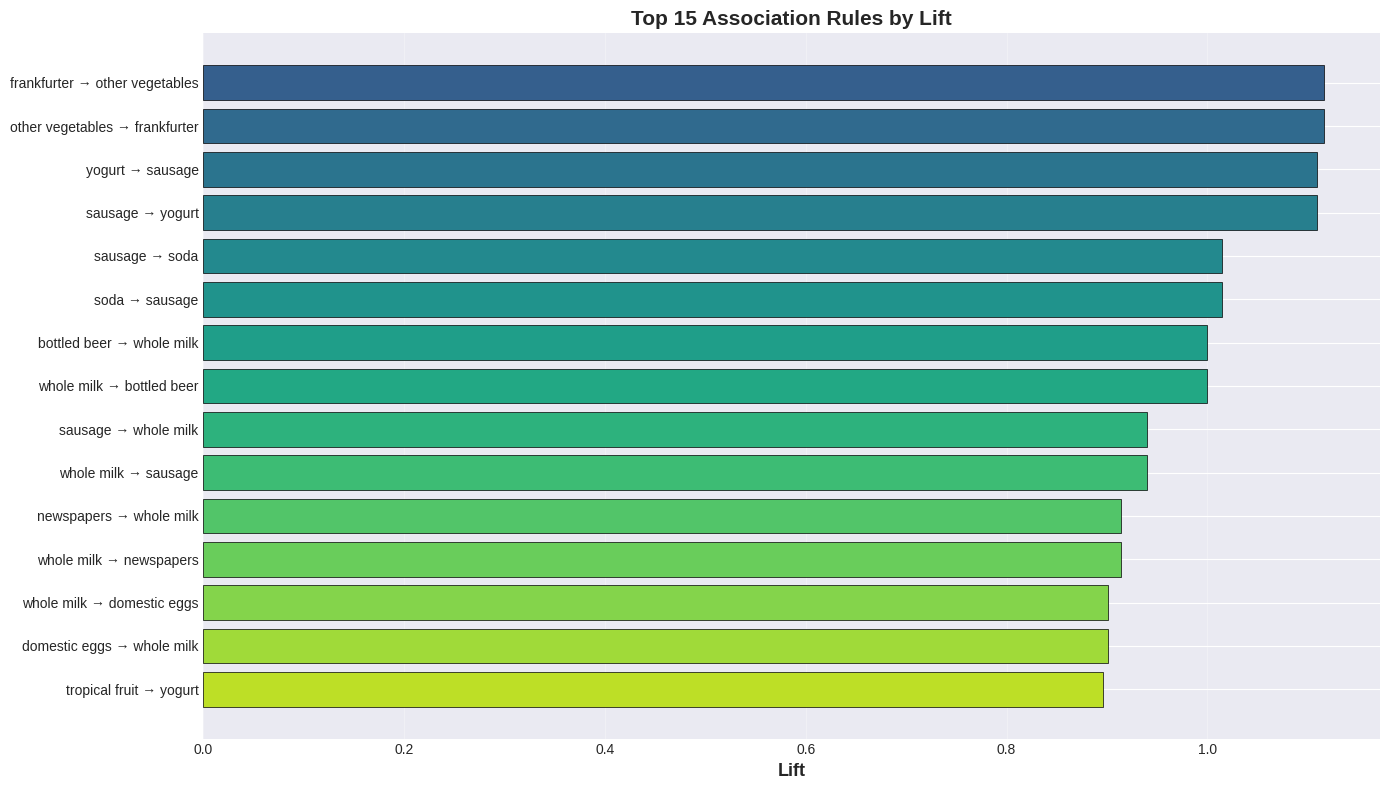

In [ ]:
# Bar plot: Top 15 rules by lift
if len(rules) > 0:
    top_rules = rules.nlargest(min(15, len(rules)), 'lift')

    plt.figure(figsize=(14, 8))
    rule_labels = [f"{list(row['antecedents'])[0] if len(row['antecedents']) == 1 else list(row['antecedents'])} → {list(row['consequents'])[0] if len(row['consequents']) == 1 else list(row['consequents'])}"
                   for _, row in top_rules.iterrows()]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_rules)))
    plt.barh(range(len(top_rules)), top_rules['lift'], color=colors, edgecolor='black', linewidth=0.5)
    plt.yticks(range(len(top_rules)), rule_labels, fontsize=10)
    plt.xlabel('Lift', fontsize=13, fontweight='bold')
    plt.title(f'Top {len(top_rules)} Association Rules by Lift', fontsize=15, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No rules to visualize. Please check the rule generation step.")

## Interpret Strong Association Rules

Let's filter and interpret the most actionable rules for business decisions.

In [ ]:
# Check if we have any rules first
if len(rules) == 0:
    print("❌ No association rules available to analyze.")
    print("Please run the previous cells to generate rules first.")
else:
    print(f"Total rules available: {len(rules):,}")
    print("\nLet's try different filtering strategies to find strong rules:\n")

    # Try progressively relaxed thresholds
    thresholds = [
        (0.4, 2.0, "Very Strong"),
        (0.3, 1.5, "Strong"),
        (0.2, 1.2, "Moderate"),
        (0.1, 1.0, "Weak")
    ]

    strong_rules = pd.DataFrame()
    threshold_used = None

    for conf_thresh, lift_thresh, label in thresholds:
        test_rules = rules[
            (rules['confidence'] > conf_thresh) &
            (rules['lift'] > lift_thresh)
        ].sort_values('lift', ascending=False)

        if len(test_rules) > 0:
            strong_rules = test_rules
            threshold_used = (conf_thresh, lift_thresh, label)
            break

    if len(strong_rules) == 0:
        print("⚠️ No rules found even with relaxed thresholds.")
        print("\n📊 Showing ALL rules sorted by Lift instead:\n")
        strong_rules = rules.sort_values('lift', ascending=False)
        threshold_used = (0, 0, "All Rules")

    conf_thresh, lift_thresh, label = threshold_used
    print(f"✓ Using '{label}' rules: Confidence > {conf_thresh:.1%}, Lift > {lift_thresh}")
    print(f"Found {len(strong_rules)} rules")
    print("="*90)
    print("\n📊 Business Insights from Top Rules:\n")

    # Show top 15 rules
    for idx, (i, rule) in enumerate(strong_rules.head(15).iterrows(), 1):
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"\n{idx}. Rule: [{antecedents}] → [{consequents}]")
        print(f"   • Support: {rule['support']:.4f} ({rule['support']*100:.2f}% of all transactions)")
        print(f"   • Confidence: {rule['confidence']:.4f} ({rule['confidence']*100:.1f}% probability)")
        print(f"   • Lift: {rule['lift']:.2f}x")
        print(f"   💡 Insight: When customers buy {antecedents}, they're {rule['lift']:.1f}x more likely to also buy {consequents}")
        print(f"   🎯 Action: Consider bundling or placing these items nearby")

Total rules available: 74

Let's try different filtering strategies to find strong rules:

✓ Using 'Weak' rules: Confidence > 10.0%, Lift > 1.0
Found 1 rules

📊 Business Insights from Top Rules:


1. Rule: [frankfurter] → [other vegetables]
   • Support: 0.0051 (0.51% of all transactions)
   • Confidence: 0.1363 (13.6% probability)
   • Lift: 1.12x
   💡 Insight: When customers buy frankfurter, they're 1.1x more likely to also buy other vegetables
   🎯 Action: Consider bundling or placing these items nearby


## Advanced Visualization: Heatmap of Support

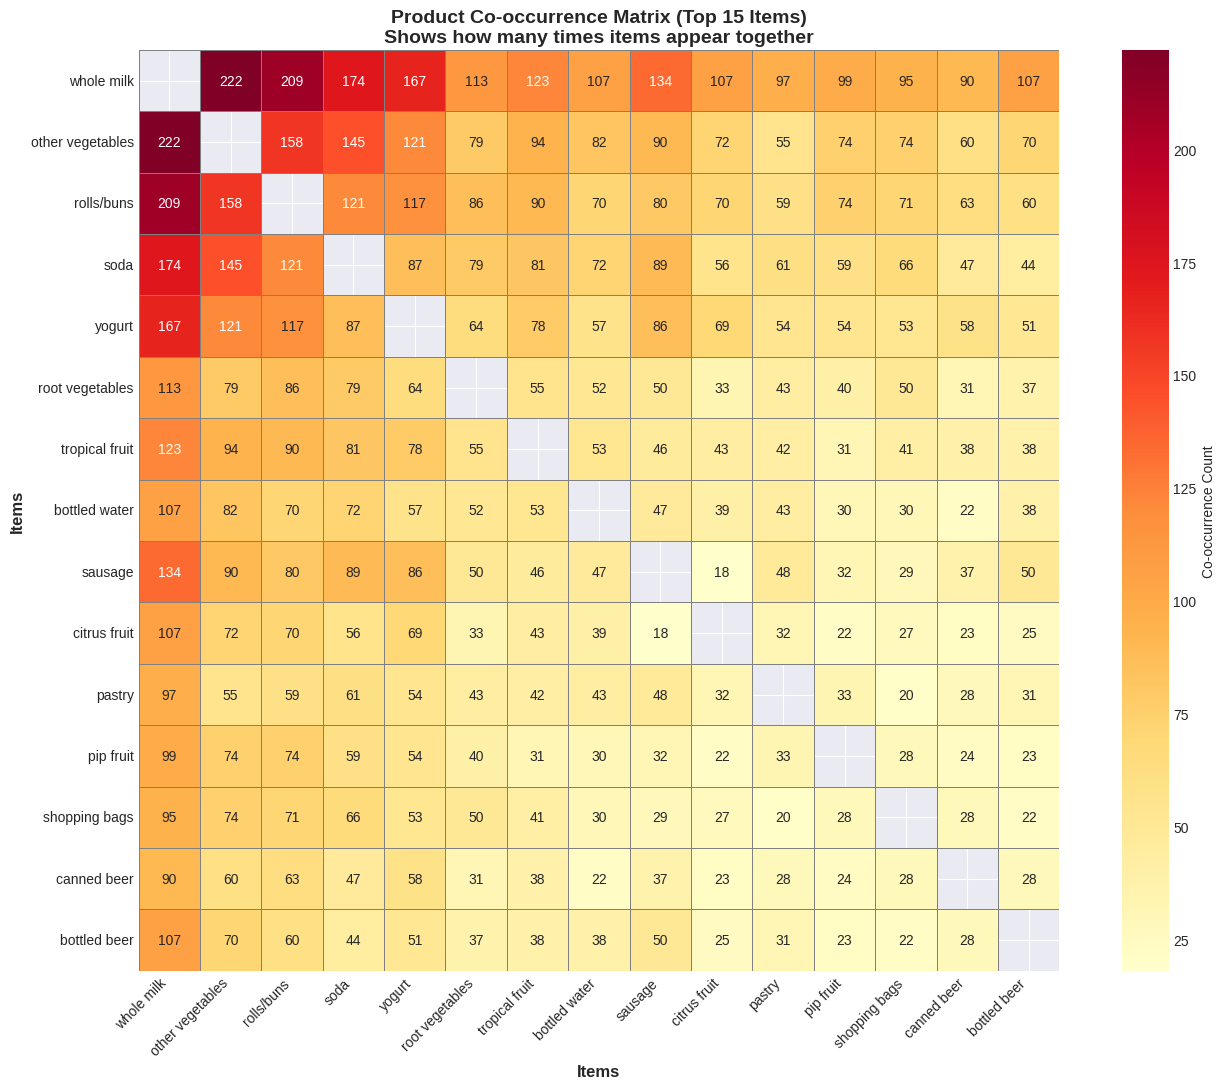


Co-occurrence Statistics:

Top 10 Item Pairs (most frequently bought together):
          Item 1           Item 2  Co-occurrence Count
      whole milk other vegetables                  222
      whole milk       rolls/buns                  209
      whole milk             soda                  174
      whole milk           yogurt                  167
other vegetables       rolls/buns                  158
other vegetables             soda                  145
      whole milk          sausage                  134
      whole milk   tropical fruit                  123
other vegetables           yogurt                  121
      rolls/buns             soda                  121


In [ ]:
# Create a heatmap showing top 15 items co-occurrence
# Select top 15 most frequent items for better visualization
top_15_items = df_encoded.sum().nlargest(15).index.tolist()
df_top15 = df_encoded[top_15_items]

# Convert to integer (0 and 1) if it's boolean
df_top15_int = df_top15.astype(int)

# Calculate co-occurrence matrix
# This shows how many times each pair of items appears together in transactions
co_occurrence = df_top15_int.T.dot(df_top15_int)

# Create a more readable version by setting diagonal to NaN (since item co-occurring with itself isn't interesting)
# Convert to float first so we can use NaN
co_occurrence_display = co_occurrence.astype(float).copy()
np.fill_diagonal(co_occurrence_display.values, np.nan)

plt.figure(figsize=(14, 11))
sns.heatmap(co_occurrence_display, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Co-occurrence Count'},
            linewidths=0.5, linecolor='gray',
            cbar=True, square=True)
plt.title('Product Co-occurrence Matrix (Top 15 Items)\nShows how many times items appear together',
          fontsize=14, fontweight='bold')
plt.xlabel('Items', fontsize=12, fontweight='bold')
plt.ylabel('Items', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCo-occurrence Statistics:")
print("=" * 70)
# Find top co-occurring pairs (excluding diagonal)
co_occurrence_pairs = []
for i in range(len(co_occurrence)):
    for j in range(i+1, len(co_occurrence)):
        co_occurrence_pairs.append({
            'Item 1': co_occurrence.index[i],
            'Item 2': co_occurrence.columns[j],
            'Co-occurrence Count': co_occurrence.iloc[i, j]
        })

df_pairs = pd.DataFrame(co_occurrence_pairs).sort_values('Co-occurrence Count', ascending=False)
print("\nTop 10 Item Pairs (most frequently bought together):")
print(df_pairs.head(10).to_string(index=False))

## Summary and Key Takeaways

### What We Learned:

1. **Market Basket Analysis** helps discover purchasing patterns and associations between products

2. **Key Metrics**:
   - **Support**: How frequently items appear together
   - **Confidence**: Likelihood of consequent given antecedent
   - **Lift**: Strength of association (>1 indicates positive correlation)

3. **Apriori Algorithm**:
   - Efficiently finds frequent itemsets
   - Uses minimum support threshold to prune search space
   - Generates association rules from frequent itemsets

4. **Business Applications**:
   - Product placement and store layout optimization
   - Cross-selling and upselling strategies
   - Recommendation systems
   - Promotional bundling

### Best Practices:

- Start with appropriate support thresholds (typically 0.01-0.1)
- Use confidence >0.5 for actionable rules
- Focus on rules with lift >1.2 for meaningful associations
- Consider domain knowledge when interpreting rules
- Regularly update rules as customer behavior changes